# Align Platemap and MOA Data

Here, I align Broad IDs in the Platemap Data to the Most Recent MOA/Target Info

In [1]:
%load_ext nb_black
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [3]:
def split_pipe_broad_id(map_subset_df, broad_id_col):
    # Split a dataframe with broad_id_cols that have pipe delimiters
    broad_split_df = (
        pd.DataFrame(
            map_subset_df.loc[:, broad_id_col]
            .squeeze()
            .dropna()
            .str.split("|")
            .tolist(),
            index=map_df.dropna(subset=[broad_id_col]).index,
        )
        .stack()
        .reset_index()
    )
    broad_split_df.columns = ["map_index", "_", "broad_id_unique"]

    map_long_df = (
        map_subset_df.merge(
            broad_split_df.loc[:, ["map_index", "broad_id_unique"]],
            left_index=True,
            right_on="map_index",
            how="left",
        )
        .reset_index(drop=True)
        .loc[:, ["InChIKey14", "broad_id_unique"]]
        .drop_duplicates()
        .assign(broad_date=broad_id_col)
        .dropna()
        .reset_index(drop=True)
    )

    return map_long_df

<IPython.core.display.Javascript object>

## Step 1: Define InChIKey14-to-Broad ID Map

In [4]:
mapping_col = "InChIKey14"

repurposing_col = "broad_id_20170327"
broad_id_other_dates = ["20170327", "20180516", "20180907", "20200324"]

<IPython.core.display.Javascript object>

In [5]:
# Load platemap data
file = pathlib.PurePath("../platemaps/broad_sample_info.tsv")
all_platemap_df = pd.read_csv(file, sep="\t").dropna(
    subset=["broad_sample", "broad_id"]
)

print(all_platemap_df.shape)
all_platemap_df.head()

(1624, 4)


,broad_sample,broad_id,plate_map_name,solvent
1,BRD-A62035778-004-03-6,BRD-A62035778,C-7161-01-LM6-018,DMSO
2,BRD-K62196610-001-01-6,BRD-K62196610,C-7161-01-LM6-018,DMSO
3,BRD-K62277907-001-01-6,BRD-K62277907,C-7161-01-LM6-018,DMSO
4,BRD-A62071884-001-04-6,BRD-A62071884,C-7161-01-LM6-018,DMSO
5,BRD-K62200014-003-10-5,BRD-K62200014,C-7161-01-LM6-018,DMSO


<IPython.core.display.Javascript object>

In [6]:
# How many unique broad IDs?
len(all_platemap_df.broad_id.unique())

1570

<IPython.core.display.Javascript object>

In [7]:
# Load MOA map
map_file = pathlib.PurePath("clue/broad_id_map.csv")
map_df = pd.read_csv(map_file)

print(map_df.shape)
map_df.head()

(6959, 13)


,InChIKey14,broad_id_20170327,deprecated_broad_id_20170327,pert_iname_20170327,broad_id_20180516,deprecated_broad_id_20180516,pert_iname_20180516,broad_id_20180907,deprecated_broad_id_20180907,pert_iname_20180907,broad_id_20200324,deprecated_broad_id_20200324,pert_iname_20200324
0,AAALVYBICLMAMA,BRD-K13087974,NaN,CGP-52411,BRD-K13087974,NaN,CGP-52411,BRD-K13087974,NaN,CGP-52411,BRD-K13087974,NaN,CGP-52411
1,AAAQFGUYHFJNHI,BRD-K08109215,NaN,I-BET-762,BRD-K08109215,NaN,I-BET-762,BRD-K08109215,NaN,I-BET-762,BRD-K08109215,NaN,I-BET-762
2,AADCDMQTJNYOSS,BRD-K50417881,NaN,eticlopride,BRD-K50417881,NaN,eticlopride,BRD-K50417881,NaN,eticlopride,BRD-K50417881,NaN,eticlopride
3,AAFJXZWCNVJTMK,BRD-K68502831,NaN,dianhydrogalactitol,BRD-K68502831,NaN,dianhydrogalactitol,BRD-K68502831,NaN,dianhydrogalactitol,BRD-K68502831,NaN,dianhydrogalactitol
4,AAGFPTSOPGCENQ,BRD-K10999968|BRD-K66845263,NaN,sophocarpine,BRD-K10999968|BRD-K66845263,NaN,sophocarpine,BRD-K66845263,BRD-K10999968,sophocarpine,BRD-K66845263,BRD-K10999968,sophocarpine


<IPython.core.display.Javascript object>

In [8]:
# Create MOA map long mapping every Broad ID to InChIKey14
all_broad_map = []
for date in broad_id_other_dates:
    broad_id_col = f"broad_id_{date}"
    deprecated_broad_id_col = f"deprecated_broad_id_{date}"

    select_cols = [mapping_col, broad_id_col, deprecated_broad_id_col]
    map_subset_df = map_df.loc[:, select_cols]

    broad_long_df = split_pipe_broad_id(map_subset_df, broad_id_col)
    all_broad_map.append(broad_long_df)

    if date != "20170327":
        deprecated_broad_long_df = split_pipe_broad_id(
            map_subset_df, deprecated_broad_id_col
        )
        all_broad_map.append(deprecated_broad_long_df)

# Combine full broad_id map
all_broad_map = (
    pd.concat(all_broad_map)
    # This step drops InChIKeys and Broad_ID combos that exist in multiple dates
    .drop_duplicates(subset=[mapping_col, "broad_id_unique"]).reset_index(drop=True)
)

print(all_broad_map.shape)
all_broad_map.head()

(8481, 3)


,InChIKey14,broad_id_unique,broad_date
0,AAALVYBICLMAMA,BRD-K13087974,broad_id_20170327
1,AAAQFGUYHFJNHI,BRD-K08109215,broad_id_20170327
2,AADCDMQTJNYOSS,BRD-K50417881,broad_id_20170327
3,AAFJXZWCNVJTMK,BRD-K68502831,broad_id_20170327
4,AAGFPTSOPGCENQ,BRD-K10999968,broad_id_20170327


<IPython.core.display.Javascript object>

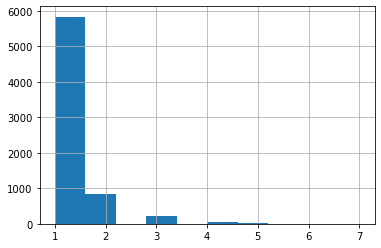

<IPython.core.display.Javascript object>

In [9]:
# Are there Duplicate InChIKey14s?
inchi_counts = all_broad_map.loc[:, mapping_col].squeeze().value_counts()
inchi_counts.hist()

In [10]:
# Show an example of the most egregious multi-mapping InChiKey14
all_broad_map.loc[all_broad_map.loc[:, mapping_col] == inchi_counts.index[0], :]

,InChIKey14,broad_id_unique,broad_date
4864,UREBDLICKHMUKA,BRD-A02180903,broad_id_20170327
4865,UREBDLICKHMUKA,BRD-A10188456,broad_id_20170327
4866,UREBDLICKHMUKA,BRD-A27572786,broad_id_20170327
4867,UREBDLICKHMUKA,BRD-K12955147,broad_id_20170327
4868,UREBDLICKHMUKA,BRD-K45192137,broad_id_20170327
6839,UREBDLICKHMUKA,BRD-K38775274,broad_id_20180907
7467,UREBDLICKHMUKA,BRD-K39188321,broad_id_20200324


<IPython.core.display.Javascript object>

## Step 2: Perform the Merge with the Platemap Data

This step identifies the InChIKey14 map for the Cell Painting Repurposing Hub Data Subset.

In [11]:
merged_platemap_df = (
    all_platemap_df.merge(
        all_broad_map, left_on="broad_id", right_on="broad_id_unique", how="left"
    )
    # We don't care about plate info here
    .drop_duplicates(subset=["broad_id", mapping_col]).loc[
        :, ["broad_sample", "broad_id", mapping_col, "broad_date"]
    ]
    # Drop DMSO
    .dropna(subset=["broad_sample"])
)

print(merged_platemap_df.shape)
merged_platemap_df.head()

(1583, 4)


,broad_sample,broad_id,InChIKey14,broad_date
0,BRD-A62035778-004-03-6,BRD-A62035778,STECJAGHUSJQJN,broad_id_20170327
1,BRD-K62196610-001-01-6,BRD-K62196610,GYCPCOJTCINIFZ,broad_id_20170327
2,BRD-K62277907-001-01-6,BRD-K62277907,GMBQZIIUCVWOCD,broad_id_20170327
3,BRD-A62071884-001-04-6,BRD-A62071884,NUHPODZZKHQQET,broad_id_20170327
4,BRD-K62200014-003-10-5,BRD-K62200014,OTBXOEAOVRKTNQ,broad_id_20170327


<IPython.core.display.Javascript object>

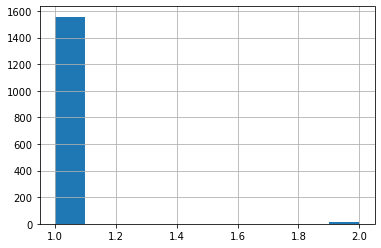

<IPython.core.display.Javascript object>

In [12]:
# Are there Duplicate Broad IDs
broad_id_counts = merged_platemap_df.broad_id.value_counts()
broad_id_counts.hist()

In [13]:
# There are indeed duplicated broad IDs!
# This means that some of these broad IDs will recieve alternative MOA/Targets
duplicate_broad_ids = broad_id_counts[broad_id_counts > 1].index.tolist()
merged_platemap_df.query("broad_id in @duplicate_broad_ids")

,broad_sample,broad_id,InChIKey14,broad_date
9,BRD-K50691590-001-02-2,BRD-K50691590,RFGAQTOFZHCFHG,broad_id_20170327
10,BRD-K50691590-001-02-2,BRD-K50691590,GXJABQQUPOEUTA,deprecated_broad_id_20180907
134,BRD-K98733875-001-01-4,BRD-K98733875,IKIIZLYTISPENI,broad_id_20170327
135,BRD-K98733875-001-01-4,BRD-K98733875,DAIGSUHCWOZEQG,deprecated_broad_id_20200324
361,BRD-K68103045-001-02-9,BRD-K68103045,XRUUVUYJUULCBQ,broad_id_20170327
362,BRD-K68103045-001-02-9,BRD-K68103045,UBLXQFIFWUEVGJ,broad_id_20200324
471,BRD-K72922393-003-15-2,BRD-K72922393,FKDHHVKWGRFRTG,broad_id_20170327
472,BRD-K72922393-003-15-2,BRD-K72922393,XZYRDNUZENBYFI,deprecated_broad_id_20180907
542,BRD-K28936863-051-33-0,BRD-K28936863,ZCVMWBYGMWKGHF,broad_id_20170327
543,BRD-K28936863-051-33-0,BRD-K28936863,OVJRNFMIYGGLDL,broad_id_20200324


<IPython.core.display.Javascript object>

## Step 3: Align Repurposing Platemap with Most Recent MOA/Target Info

In [14]:
# Load Data
moa_file = "repurposing_info.tsv"
moa_df = pd.read_csv(moa_file, sep="\t")

print(moa_df.shape)
moa_df.head()

(13553, 18)


,broad_id,pert_iname,clinical_phase,moa,target,disease_area,indication,qc_incompatible,purity,vendor,catalog_no,vendor_name,expected_mass,smiles,InChIKey,pubchem_cid,deprecated_broad_id,InChIKey14
0,BRD-K76022557-003-28-9,(R)-(-)-apomorphine,Launched,dopamine receptor agonist,ADRA2A|ADRA2B|ADRA2C|CALY|DRD1|DRD2|DRD3|DRD4|...,neurology/psychiatry,Parkinson's Disease,0,98.90,MedChemEx,HY-12723A,Apomorphine (hydrochloride hemihydrate),267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN,VMWNQDUVQKEIOC
1,BRD-K76022557-003-02-7,(R)-(-)-apomorphine,Launched,dopamine receptor agonist,ADRA2A|ADRA2B|ADRA2C|CALY|DRD1|DRD2|DRD3|DRD4|...,neurology/psychiatry,Parkinson's Disease,0,97.34,Tocris,2073,(R)-(-)-Apomorphine hydrochloride,267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN,VMWNQDUVQKEIOC
2,BRD-K76022557-003-29-9,(R)-(-)-apomorphine,Launched,dopamine receptor agonist,ADRA2A|ADRA2B|ADRA2C|CALY|DRD1|DRD2|DRD3|DRD4|...,neurology/psychiatry,Parkinson's Disease,0,97.36,Tocris,2073,(R)-(-)-Apomorphine hydrochloride,267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN,VMWNQDUVQKEIOC
3,BRD-K76022557-001-03-9,(R)-(-)-apomorphine,Launched,dopamine receptor agonist,ADRA2A|ADRA2B|ADRA2C|CALY|DRD1|DRD2|DRD3|DRD4|...,neurology/psychiatry,Parkinson's Disease,0,95.80,Selleck,S4350,R-(-)-Apomorphine HCl Hemihydrate,267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN,VMWNQDUVQKEIOC
4,BRD-K75516118-001-04-1,(R)-(-)-rolipram,Phase 1,phosphodiesterase inhibitor,PDE4A|PDE4B|PDE4C|PDE4D|PDE5A,NaN,NaN,0,93.92,Tocris,1349,(R)-(-)-Rolipram,275.152,COc1ccc(cc1OC1CCCC1)[C@@H]1CNC(=O)C1,HJORMJIFDVBMOB-LBPRGKRZSA-N,448055.0,NaN,HJORMJIFDVBMOB


<IPython.core.display.Javascript object>

In [15]:
# Perform the alignment
platemap_moa_df = merged_platemap_df.merge(
    moa_df.loc[
        :, [mapping_col, "pert_iname", "clinical_phase", "moa", "target"]
    ].drop_duplicates(),
    on=mapping_col,
    how="left",
).loc[
    :,
    [
        "broad_sample",
        "broad_id",
        "pert_iname",
        mapping_col,
        "moa",
        "target",
        "broad_date",
        "clinical_phase",
    ],
]

print(platemap_moa_df.shape)
platemap_moa_df.head()

(1631, 8)


,broad_sample,broad_id,pert_iname,InChIKey14,moa,target,broad_date,clinical_phase
0,BRD-A62035778-004-03-6,BRD-A62035778,scopolamine,STECJAGHUSJQJN,acetylcholine receptor antagonist,CHRM1|CHRM2|CHRM3|CHRM4|CHRM5|SI,broad_id_20170327,Launched
1,BRD-K62196610-001-01-6,BRD-K62196610,AVN-944,GYCPCOJTCINIFZ,inosine monophosphate dehydrogenase inhibitor,IMPDH1|IMPDH2,broad_id_20170327,Phase 2
2,BRD-K62277907-001-01-6,BRD-K62277907,PYM50028,GMBQZIIUCVWOCD,neurotrophic agent,NaN,broad_id_20170327,Phase 2
3,BRD-A62071884-001-04-6,BRD-A62071884,siguazodan,NUHPODZZKHQQET,phosphodiesterase inhibitor,PDE3A,broad_id_20170327,Phase 1
4,BRD-K62200014-003-10-5,BRD-K62200014,anagrelide,OTBXOEAOVRKTNQ,phosphodiesterase inhibitor,PDE3A,broad_id_20170327,Launched


<IPython.core.display.Javascript object>

In [16]:
# Show an example of a broad_id that must be resolved
platemap_moa_df.query("broad_id == 'BRD-K56844688'")

,broad_sample,broad_id,pert_iname,InChIKey14,moa,target,broad_date,clinical_phase
1587,BRD-K56844688-003-01-2,BRD-K56844688,doxorubicin,AOJJSUZBOXZQNB,topoisomerase inhibitor,TOP2A,broad_id_20170327,Launched
1588,BRD-K56844688-003-01-2,BRD-K56844688,epirubicin,AOJJSUZBOXZQNB,topoisomerase inhibitor,CHD1|TOP2A,broad_id_20170327,Launched


<IPython.core.display.Javascript object>

## Step 5 - Quantify what's missing

In [17]:
# Some samples are missing an InChIKey14
platemap_moa_with_inchi_df = platemap_moa_df.dropna(subset=[mapping_col])

print(platemap_moa_with_inchi_df.shape)
platemap_moa_with_inchi_df.head()

(1613, 8)


,broad_sample,broad_id,pert_iname,InChIKey14,moa,target,broad_date,clinical_phase
0,BRD-A62035778-004-03-6,BRD-A62035778,scopolamine,STECJAGHUSJQJN,acetylcholine receptor antagonist,CHRM1|CHRM2|CHRM3|CHRM4|CHRM5|SI,broad_id_20170327,Launched
1,BRD-K62196610-001-01-6,BRD-K62196610,AVN-944,GYCPCOJTCINIFZ,inosine monophosphate dehydrogenase inhibitor,IMPDH1|IMPDH2,broad_id_20170327,Phase 2
2,BRD-K62277907-001-01-6,BRD-K62277907,PYM50028,GMBQZIIUCVWOCD,neurotrophic agent,NaN,broad_id_20170327,Phase 2
3,BRD-A62071884-001-04-6,BRD-A62071884,siguazodan,NUHPODZZKHQQET,phosphodiesterase inhibitor,PDE3A,broad_id_20170327,Phase 1
4,BRD-K62200014-003-10-5,BRD-K62200014,anagrelide,OTBXOEAOVRKTNQ,phosphodiesterase inhibitor,PDE3A,broad_id_20170327,Launched


<IPython.core.display.Javascript object>

In [18]:
# How many broad ids are missing an inchi key?
missing_inchi_key = set(platemap_moa_df.broad_id.unique()).difference(
    set(platemap_moa_with_inchi_df.broad_id)
)
len(missing_inchi_key)

18

<IPython.core.display.Javascript object>

In [19]:
# How many unique broad ids?
all_unique_broad_platemap_ids = set(platemap_moa_df.broad_id.unique())
len(all_unique_broad_platemap_ids)

1570

<IPython.core.display.Javascript object>

In [20]:
# How many unique pert inames
len(set(platemap_moa_with_inchi_df.pert_iname))

1553

<IPython.core.display.Javascript object>

In [21]:
# How many broad ids with complete moa and target info?
complete_info = set(
    platemap_moa_with_inchi_df.loc[
        ~(
            platemap_moa_with_inchi_df.moa.isna()
            | platemap_moa_with_inchi_df.target.isna()
        ),
        "broad_id",
    ].values
)
len(complete_info)

1285

<IPython.core.display.Javascript object>

In [22]:
# How many examples of broad ids with missing moa?
moa_missing = set(
    platemap_moa_with_inchi_df.sort_values(by="moa", na_position="last")
    .drop_duplicates(subset="broad_id", keep="first")
    .loc[platemap_moa_with_inchi_df.moa.isna(), "broad_id"]
    .values
).difference(complete_info)

moa_present = all_unique_broad_platemap_ids.difference(moa_missing)
len(moa_missing)

34

<IPython.core.display.Javascript object>

In [23]:
# How many examples of broad ids with missing targets?
target_missing = set(
    platemap_moa_with_inchi_df.sort_values(by="target", na_position="last")
    .drop_duplicates(subset="broad_id", keep="first")
    .loc[platemap_moa_with_inchi_df.target.isna(), "broad_id"]
    .values
).difference(complete_info)

target_present = all_unique_broad_platemap_ids.difference(target_missing)
len(target_missing)

266

<IPython.core.display.Javascript object>

In [24]:
missing_moa_info = moa_missing.difference(target_missing)
len(missing_moa_info)

1

<IPython.core.display.Javascript object>

In [25]:
missing_target_info = target_missing.difference(moa_missing)
len(missing_target_info)

233

<IPython.core.display.Javascript object>

In [26]:
missing_both_info = moa_missing.intersection(target_missing)

missing_both_info = (
    missing_both_info.difference(complete_info)
    .difference(target_present)
    .difference(moa_present)
)
len(missing_both_info)

33

<IPython.core.display.Javascript object>

In [27]:
pd.DataFrame(
    {
        "Unique Broad IDs": len(all_unique_broad_platemap_ids),
        "Broad IDs with Complete MOA/Target": len(complete_info),
        "Missing InChIKey14": len(missing_inchi_key),
        "Broad IDs with Only Missing MOA Info": len(missing_moa_info),
        "Broad IDs with Only Missing Target Info": len(missing_target_info),
        "Broad IDs Missing Both MOA and Target": len(missing_both_info),
    },
    index=["count"],
).transpose()

,count
Unique Broad IDs,1570
Broad IDs with Complete MOA/Target,1285
Missing InChIKey14,18
Broad IDs with Only Missing MOA Info,1
Broad IDs with Only Missing Target Info,233
Broad IDs Missing Both MOA and Target,33


<IPython.core.display.Javascript object>

## Step 6 - Resolve Stereochemistry Differences

In [28]:
alternative_delim = ";"

<IPython.core.display.Javascript object>

In [29]:
# Drop rows in the following scenario:
# 1. The broad_id is assigned with two or more InChIKey14
# 2. Drop InChIKey14s in these rows that have missing values in both moa and target

broad_id_with_multiple_inchi = (
    platemap_moa_with_inchi_df.groupby("broad_id")[mapping_col]
    .count()
    .sort_values(ascending=False)
)

broad_id_with_singular_inchi = set(
    broad_id_with_multiple_inchi[broad_id_with_multiple_inchi == 1].index
)
print(f"Only one InChIKey14: {len(broad_id_with_singular_inchi)}")

broad_id_with_multiple_inchi = set(
    broad_id_with_multiple_inchi[broad_id_with_multiple_inchi > 1].index
)
print(f"More than one InChIKey14: {len(broad_id_with_multiple_inchi)}")

Only one InChIKey14: 1497
More than one InChIKey14: 55


<IPython.core.display.Javascript object>

In [30]:
# First, drop entries that have missing values in BOTH moa and target
# Also drop duplicated columns
platemap_multiple_inchi_select_df = platemap_moa_with_inchi_df.query(
    "broad_id in @broad_id_with_multiple_inchi"
)

platemap_multiple_inchi_select_df = platemap_multiple_inchi_select_df.loc[
    ~(
        platemap_multiple_inchi_select_df.moa.isna()
        & platemap_multiple_inchi_select_df.target.isna()
    )
].drop_duplicates()

print(platemap_multiple_inchi_select_df.shape)
platemap_multiple_inchi_select_df.head(20)

assert len(broad_id_with_multiple_inchi) == len(
    platemap_multiple_inchi_select_df.broad_id.unique()
), "Stop, a broad ID was dropped somewhere that shouldn't have"

(101, 8)


<IPython.core.display.Javascript object>

In [31]:
# After this step, are there any resolved broad_ids?
first_step_resolve = platemap_multiple_inchi_select_df.broad_id.value_counts()
first_step_resolve = list(first_step_resolve[first_step_resolve == 1].index)

first_step_resolve_df = platemap_multiple_inchi_select_df.query(
    "broad_id in @first_step_resolve"
).reset_index(drop=True)

print(first_step_resolve_df.shape)
first_step_resolve_df.head()

(14, 8)


,broad_sample,broad_id,pert_iname,InChIKey14,moa,target,broad_date,clinical_phase
0,BRD-K50691590-001-02-2,BRD-K50691590,bortezomib,GXJABQQUPOEUTA,NFkB pathway inhibitor|proteasome inhibitor,PSMA1|PSMA2|PSMA3|PSMA4|PSMA5|PSMA6|PSMA7|PSMA...,deprecated_broad_id_20180907,Launched
1,BRD-K98733875-001-01-4,BRD-K98733875,baicalin,DAIGSUHCWOZEQG,beta glucuronidase inhibitor,PREP,deprecated_broad_id_20200324,Launched
2,BRD-K68103045-001-02-9,BRD-K68103045,CGS-20625,UBLXQFIFWUEVGJ,benzodiazepine receptor agonist|GABA benzodiaz...,GABRA1|GABRA2|GABRA3|GABRA4|GABRA5|GABRA6,broad_id_20200324,Phase 1
3,BRD-K72922393-003-15-2,BRD-K72922393,linsidomine,XZYRDNUZENBYFI,nitric oxide donor,NaN,deprecated_broad_id_20180907,Launched
4,BRD-K28936863-051-33-0,BRD-K28936863,ketotifen,OVJRNFMIYGGLDL,histamine receptor agonist|leukotriene recepto...,HRH1,broad_id_20200324,Launched


<IPython.core.display.Javascript object>

In [32]:
# Remove these from other broad IDs that need to be resolved
platemap_alternative_inchi_df = platemap_multiple_inchi_select_df.query(
    "broad_id not in @first_step_resolve"
).drop_duplicates(["broad_id", "moa", "target"])

platemap_alternative_inchi_df = platemap_alternative_inchi_df.assign(
    deprecated=[x[0] for x in platemap_alternative_inchi_df.broad_date.str.split("_")]
)

assert (
    len(platemap_alternative_inchi_df.deprecated.unique()) == 1
), "Warning! Deprecated info should not be resolved"

print(platemap_alternative_inchi_df.shape)
platemap_alternative_inchi_df.head()

(80, 9)


,broad_sample,broad_id,pert_iname,InChIKey14,moa,target,broad_date,clinical_phase,deprecated
63,BRD-A20239487-001-24-9,BRD-A20239487,atenolol-(+),METKIMKYRPQLGS,adrenergic receptor antagonist,NaN,broad_id_20170327,Preclinical,broad
64,BRD-A20239487-001-24-9,BRD-A20239487,atenolol-(+/-),METKIMKYRPQLGS,adrenergic receptor antagonist,ADRB1|ADRB2|LTF|PLA2G2E,broad_id_20170327,Launched,broad
106,BRD-K78431006-001-10-2,BRD-K78431006,crizotinib,KTEIFNKAUNYNJU,ALK tyrosine kinase receptor inhibitor,ALK|MET,broad_id_20170327,Launched,broad
107,BRD-K78431006-001-10-2,BRD-K78431006,crizotinib-(S),KTEIFNKAUNYNJU,MTH1 inhibitor,NUDT1,broad_id_20170327,Preclinical,broad
118,BRD-A97701745-001-16-0,BRD-A97701745,pindolol,JZQKKSLKJUAGIC,adrenergic receptor antagonist,ADRB1|ADRB2|HTR1A|HTR2A|HTR2B,broad_id_20170327,Launched,broad


<IPython.core.display.Javascript object>

In [33]:
# Now resolve the remaining broad_ids
alternative_resolved_df = []
for broad_id in platemap_alternative_inchi_df.broad_id.unique():
    subset_platemap_alternative_inchi_df = platemap_alternative_inchi_df.query(
        "broad_id == @broad_id"
    ).reset_index(drop=True)

    primary_moa_df = subset_platemap_alternative_inchi_df.iloc[0, :]
    alternative_moa_df = subset_platemap_alternative_inchi_df.drop(
        primary_moa_df.name, axis="rows"
    )

    moa_join = alternative_delim.join([str(x) for x in alternative_moa_df.moa.tolist()])
    target_join = alternative_delim.join(
        [str(x) for x in alternative_moa_df.target.tolist()]
    )
    alternative_resolved_df.append(
        pd.DataFrame(primary_moa_df)
        .transpose()
        .assign(alternative_moa=moa_join, alternative_target=target_join)
    )

alternative_resolved_df = pd.concat(alternative_resolved_df)

assert sorted(alternative_resolved_df.broad_id) == sorted(
    platemap_alternative_inchi_df.broad_id.unique()
), "Warning, something went missing along the way"

assert (
    alternative_resolved_df.broad_id.value_counts().sum()
    == alternative_resolved_df.shape[0]
), "Warning, there are still duplicate broad_ids"

print(alternative_resolved_df.shape)
alternative_resolved_df.head()

(41, 11)


,broad_sample,broad_id,pert_iname,InChIKey14,moa,target,broad_date,clinical_phase,deprecated,alternative_moa,alternative_target
0,BRD-A20239487-001-24-9,BRD-A20239487,atenolol-(+),METKIMKYRPQLGS,adrenergic receptor antagonist,NaN,broad_id_20170327,Preclinical,broad,adrenergic receptor antagonist,ADRB1|ADRB2|LTF|PLA2G2E
0,BRD-K78431006-001-10-2,BRD-K78431006,crizotinib,KTEIFNKAUNYNJU,ALK tyrosine kinase receptor inhibitor,ALK|MET,broad_id_20170327,Launched,broad,MTH1 inhibitor,NUDT1
0,BRD-A97701745-001-16-0,BRD-A97701745,pindolol,JZQKKSLKJUAGIC,adrenergic receptor antagonist,ADRB1|ADRB2|HTR1A|HTR2A|HTR2B,broad_id_20170327,Launched,broad,adrenergic receptor antagonist|serotonin recep...,HTR1A
0,BRD-K87300616-001-01-9,BRD-K87300616,chenodeoxycholic-acid,RUDATBOHQWOJDD,11-beta hydroxysteroid dehydrogenase inhibitor...,HSD11B1|NR1H4,broad_id_20170327,Launched,broad,nuclear factor erythroid derived|like (NRF2) a...,AKR1C2|NR1H4
0,BRD-A05457250-001-05-0,BRD-A05457250,BAY-K-8644-(+/-),ZFLWDHHVRRZMEI,L-type calcium channel blocker,NaN,broad_id_20170327,Preclinical,broad,L-type calcium channel activator,CACNA1C


<IPython.core.display.Javascript object>

## Step 7 - Combine Annotated Platemap with Resolution

In [34]:
# First, remove the broad_ids that needed to be resolved
resolved_broad_ids = (
    alternative_resolved_df.broad_id.tolist() + first_step_resolve_df.broad_id.tolist()
)

platemap_moa_easy_df = platemap_moa_df.query("broad_id not in @resolved_broad_ids")

assert (
    platemap_moa_easy_df.broad_id.value_counts().sum() == platemap_moa_easy_df.shape[0]
), "Error, there are still broad_ids that require resolution"

<IPython.core.display.Javascript object>

In [35]:
platemap_moa_easy_df = platemap_moa_easy_df.assign(
    alternative_moa=np.nan, alternative_target=np.nan
)

first_step_resolve_df = first_step_resolve_df.assign(
    alternative_moa=np.nan, alternative_target=np.nan
)

<IPython.core.display.Javascript object>

In [36]:
moa_map_df = (
    pd.concat([platemap_moa_easy_df, first_step_resolve_df, alternative_resolved_df])
    .sort_values(by="broad_id")
    .reset_index(drop=True)
    .drop("deprecated", axis="columns")
)

assert (
    moa_map_df.broad_id.value_counts().sum() == moa_map_df.shape[0]
), "Error, broad_ids have been duplicated somewhere along the way"

print(moa_map_df.shape)
moa_map_df.head()

(1570, 10)


,broad_sample,broad_id,pert_iname,InChIKey14,moa,target,broad_date,clinical_phase,alternative_moa,alternative_target
0,BRD-A00147595-001-01-5,BRD-A00147595,balaglitazone,IETKPTYAGKZLKY,insulin sensitizer|PPAR receptor partial agonist,PPARG,broad_id_20170327,Phase 3,NaN,NaN
1,BRD-A00218260-001-03-4,BRD-A00218260,flutrimazole,QHMWCHQXCUNUAK,sterol demethylase inhibitor,NaN,broad_id_20170327,Launched,NaN,NaN
2,BRD-A00376169-001-01-6,BRD-A00376169,KBG,FOLRUCXBTYDAQK,neprilysin inhibitor,MME,broad_id_20170327,Phase 2,NaN,NaN
3,BRD-A00546892-001-02-6,BRD-A00546892,biperiden,YSXKPIUOCJLQIE,acetylcholine receptor antagonist,CHRM1|CHRM2|CHRM3|CHRM4|CHRM5,broad_id_20170327,Launched,NaN,NaN
4,BRD-A00938334-001-01-3,BRD-A00938334,drospirenone,METQSPRSQINEEU,mineralocorticoid receptor antagonist,AR|NR3C2|PGR,broad_id_20170327,Launched,NaN,NaN


<IPython.core.display.Javascript object>

In [37]:
# Interpretation: This is the CLUE version the 2020 CLUE version (most recent) used to map
moa_map_df.broad_date.value_counts()

broad_id_20170327               1540
broad_id_20200324                  7
deprecated_broad_id_20180907       3
deprecated_broad_id_20180516       1
deprecated_broad_id_20200324       1
Name: broad_date, dtype: int64

<IPython.core.display.Javascript object>

In [38]:
map_output_file = "repurposing_info_external_moa_map_resolved.tsv"
moa_map_df.to_csv(map_output_file, sep="\t", index=False)

<IPython.core.display.Javascript object>

In [39]:
pd.DataFrame(
    {
        "All Unique Broad IDs": len(all_unique_broad_platemap_ids),
        "One-to-One Mapping": platemap_moa_easy_df.query(
            "broad_id not in list(@missing_inchi_key)"
        ).shape[0],
        "Missing InChiKey14": len(missing_inchi_key),
        "Duplicate InChIKey14 with both MOA/Target Missing": first_step_resolve_df.shape[
            0
        ],
        "Duplicate InChIKey14 requires alternative MOA/Target annotations": alternative_resolved_df.shape[
            0
        ],
    },
    index=["count"],
).transpose()

,count
All Unique Broad IDs,1570
One-to-One Mapping,1497
Missing InChiKey14,18
Duplicate InChIKey14 with both MOA/Target Missing,14
Duplicate InChIKey14 requires alternative MOA/Target annotations,41


<IPython.core.display.Javascript object>